Epoch 1/50
391/391 [==============================] - 4s 7ms/step - loss: 0.5814 - val_loss: 0.5691
Epoch 2/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5662 - val_loss: 0.5669
Epoch 3/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5637 - val_loss: 0.5639
Epoch 4/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5624 - val_loss: 0.5637
Epoch 5/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5615 - val_loss: 0.5629
Epoch 6/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5608 - val_loss: 0.5613
Epoch 7/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5604 - val_loss: 0.5627
Epoch 8/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5600 - val_loss: 0.5605
Epoch 9/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5597 - val_loss: 0.5604
Epoch 10/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5594 - val_loss: 0.5605

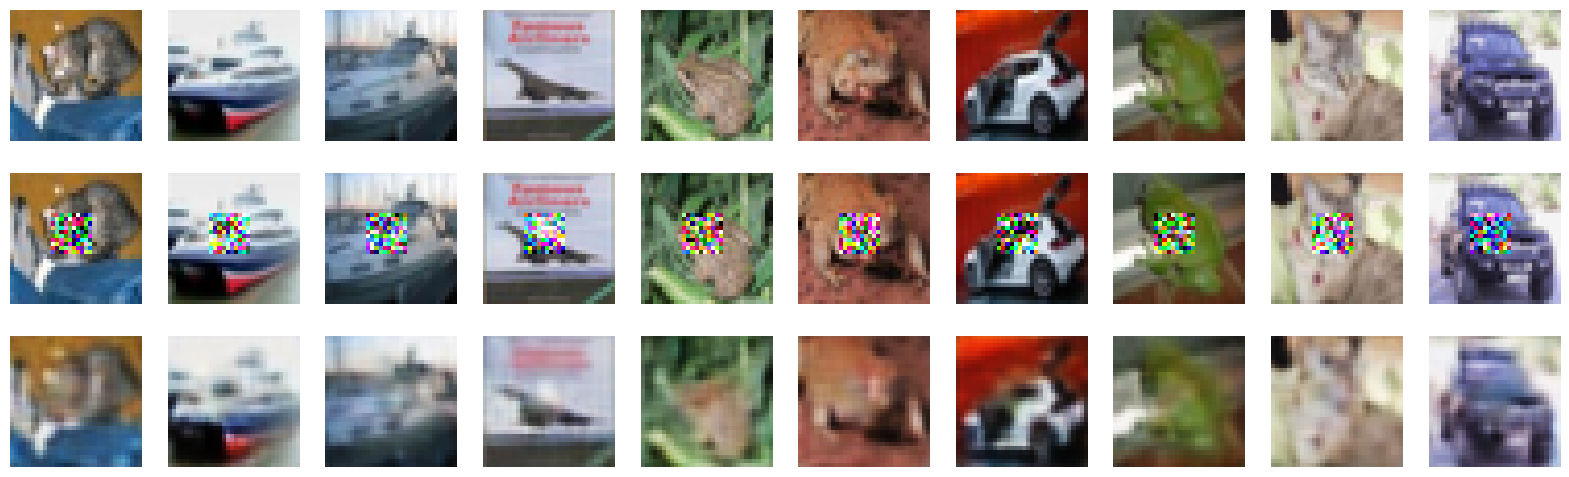

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 128]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self.conv_block(feature * 2, feature))

        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.pad(x, [0, skip_connection.shape[3] - x.shape[3], 0, skip_connection.shape[2] - x.shape[2]])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

# Instantiate the model and optimizer
model = UNet(in_channels=3)  # Specify 3 input channels
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the forward diffusion process
def add_noise(images, noise_factor=0.5, noise_region=(slice(10, 20), slice(10, 20))):
    noisy_images = images.copy()
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=noisy_images[:, noise_region[0], noise_region[1], :].shape)
    noisy_images[:, noise_region[0], noise_region[1], :] += noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_train_images = add_noise(train_images)
noisy_test_images = add_noise(test_images)

# Define the reverse process (denoising model)
def build_denoising_model(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    diffusion = Model(input_img, decoded)
    return diffusion

input_shape = (32, 32, 3)
diffusion = build_denoising_model(input_shape)
diffusion.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = diffusion.fit(
    noisy_train_images, train_images,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_images, test_images)
)

# Function to display images
def display_images(original, noisy, denoised, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i])
        ax.axis('off')

        # Display noisy images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i])
        ax.axis('off')

        # Display denoised images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i])
        ax.axis('off')

    plt.show()

# Select a subset of the test images
num_images_to_display = 10
test_images_subset = test_images[:num_images_to_display]
noisy_test_images_subset = noisy_test_images[:num_images_to_display]

# Get the denoised images
denoised_images = diffusion.predict(noisy_test_images_subset)

# Display the images
display_images(test_images_subset, noisy_test_images_subset, denoised_images)


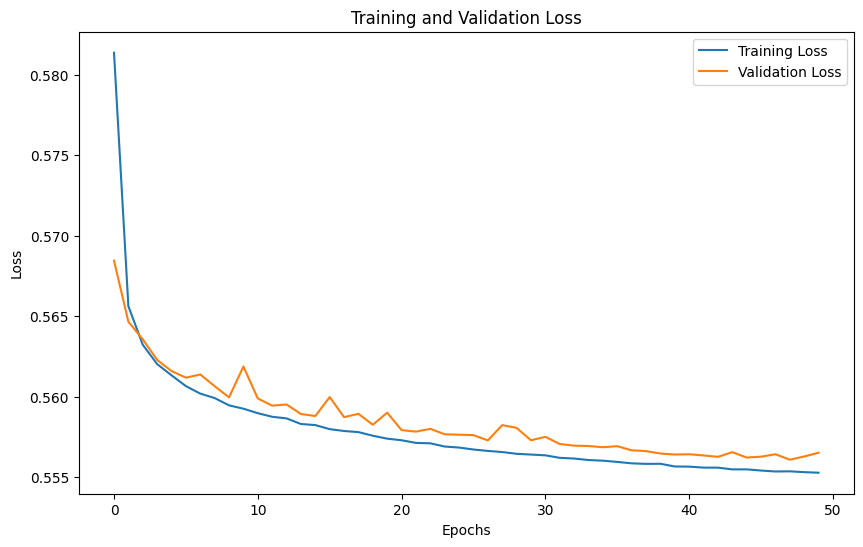

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

def calculate_ssim(original, denoised):
    ssim_values = []
    for i in range(original.shape[0]):
        ssim_value = tf.image.ssim(original[i], denoised[i], max_val=1.0).numpy()
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

def calculate_psnr(original, denoised):
    psnr_values = []
    for i in range(original.shape[0]):
        psnr_value = tf.image.psnr(original[i], denoised[i], max_val=1.0).numpy()
        psnr_values.append(psnr_value)
    return np.mean(psnr_values)

ssim_value = calculate_ssim(test_images_subset, denoised_images)
psnr_value = calculate_psnr(test_images_subset, denoised_images)

print(f"SSIM: {ssim_value}")
print(f"PSNR: {psnr_value}")


SSIM: 0.7760472297668457
PSNR: 24.918752670288086


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Load the InceptionV3 model for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Function to preprocess images for InceptionV3
def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

# Extract features using InceptionV3
def get_features(images):
    images_preprocessed = preprocess_images(images)
    features = inception_model.predict(images_preprocessed)
    return features

# Calculate FID score
def calculate_fid(real_images, generated_images):
    real_features = get_features(real_images)
    generated_features = get_features(generated_images)

    # Calculate the mean and covariance of the features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate the Fréchet distance
    ssdiff = np.sum((mu_real - mu_generated)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

fid_score = calculate_fid(test_images_subset, denoised_images)

print(f"FID Score: {fid_score}")


1/1 [==============================] - 0s 32ms/step
FID Score: 5.703700733736561e+93


In [ ]:
from sklearn.metrics import mean_squared_error

# Function to compute the Mean Squared Error between original and denoised images
def compute_mse(original, denoised):
    mse_values = []
    for orig, denoi in zip(original, denoised):
        mse_values.append(mean_squared_error(orig.flatten(), denoi.flatten()))
    return np.mean(mse_values)

# Compute the MSE on the test set
mse = compute_mse(test_images, diffusion.predict(noisy_test_images))
print(f'Mean Squared Error: {mse}')


313/313 [==============================] - 1s 2ms/step
Mean Squared Error: 0.0033770615700632334


In [ ]:
!pip install tensorflow
!pip install scipy

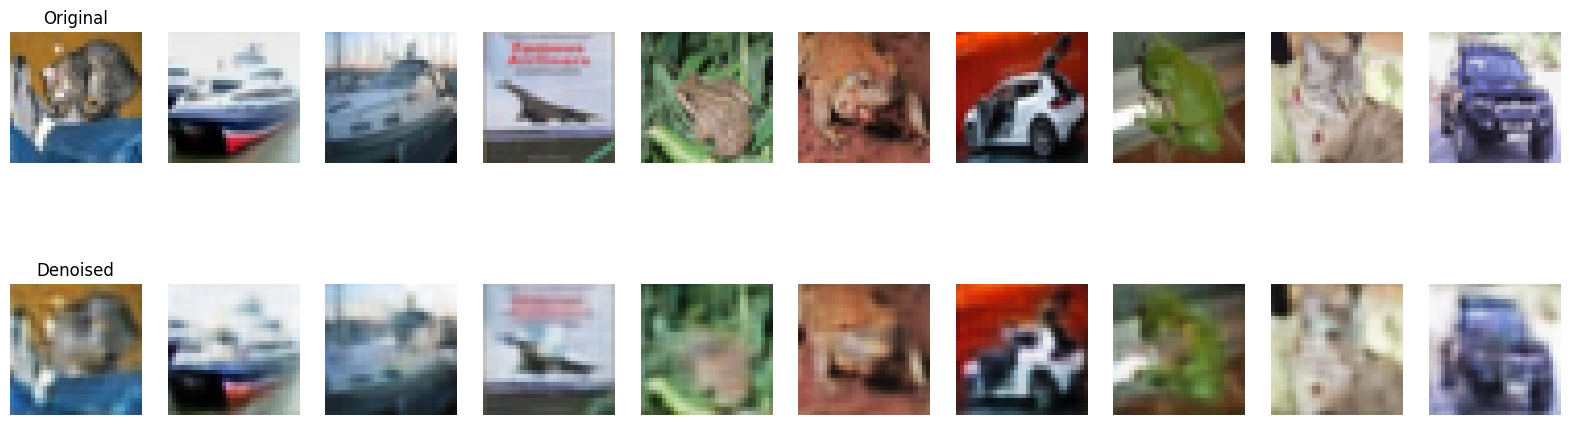

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_confusion_matrix(original, denoised, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Display denoised images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(denoised[i])
        ax.axis('off')
        if i == 0:
            ax.set_title('Denoised')

    plt.show()

# Display confusion matrix
display_confusion_matrix(test_images_subset, denoised_images)


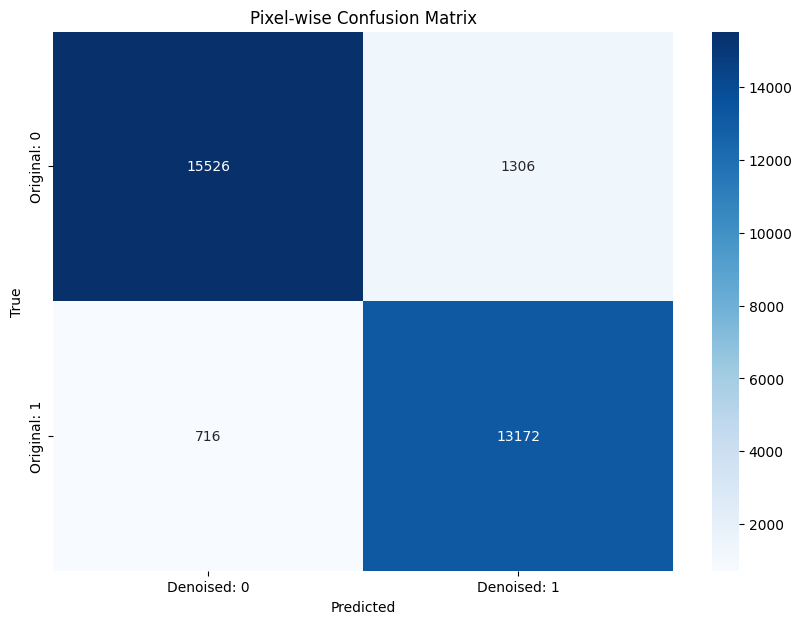

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Binarize the images with a threshold
def binarize_images(images, threshold=0.5):
    return (images > threshold).astype(int)

# Binarize the original and denoised images
binary_test_images = binarize_images(test_images_subset)
binary_denoised_images = binarize_images(denoised_images)

# Flatten the images to create a single array of pixels for comparison
flattened_original = binary_test_images.flatten()
flattened_denoised = binary_denoised_images.flatten()

# Compute the confusion matrix
cm = confusion_matrix(flattened_original, flattened_denoised)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denoised: 0', 'Denoised: 1'], yticklabels=['Original: 0', 'Original: 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Pixel-wise Confusion Matrix')
plt.show()


In [ ]:
# Calculate derived metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')


Accuracy: 0.9342
Precision: 0.9098
Recall: 0.9484
F1 Score: 0.9287


1/1 [==============================] - 0s 26ms/step


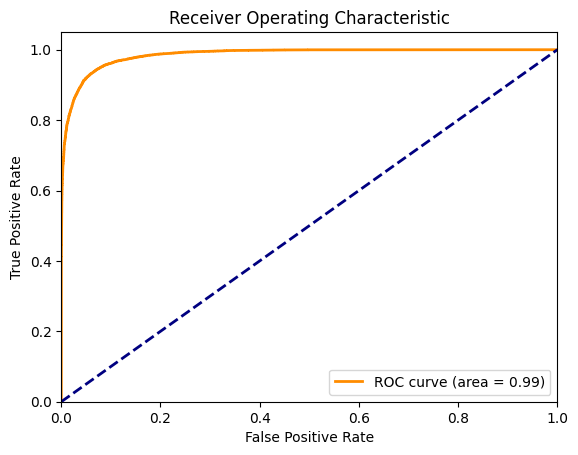

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the probabilities (denoised images) from the model
denoised_images_prob = diffusion.predict(noisy_test_images_subset)

# Flatten the original and denoised images for comparison
flattened_original = test_images_subset.flatten()
flattened_denoised_prob = denoised_images_prob.flatten()

# Binarize the original images
threshold = 0.5
binary_original = (flattened_original > threshold).astype(int)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(binary_original, flattened_denoised_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
